In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
from DTW import dtwPlotTwoWay, dtw_easy
import random
from tqdm import tqdm
from scipy.interpolate import CubicSpline


In [13]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [14]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    # plt.figure()
    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
        # plt.plot(signal[begin: end])
    # plt.show()
    return pieces

In [15]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()


    return [dis12/dis21, A0/A1]

In [16]:
def performNLAAF1(pieces):
    # 2^N
    # 1. drop out something
    # 2. use loops to simulate recursive
    # 3. get the template
    pieces_num = len(pieces)
    k = 1
    while pieces_num >= k:
        k *= 2
    k = int(k/2)

    random_choice = random.sample(range(pieces_num), k)
    chosen_pieces = [pieces[choice] for choice in random_choice]

    dist = lambda x, y: np.abs(x - y)

    this_term = chosen_pieces

    while k > 1:
        last_term = this_term
        this_term = []

        for cnt in range(0, k, 2):
            a = cnt
            b = cnt + 1
            piece1, piece2 = last_term[a], last_term[b]

            _, _, _, path = dtw_easy(piece1, piece2, dist)
            template = make_template(piece1, piece2, path)
            this_term.append(template)

        k = int(k / 2)

    return np.array(this_term[0])

def performNLAAF2(pieces):
    # one by one
    # 1. use loops to calculate
    # 2. get the template
    pieces_num = len(pieces)
    dist = lambda x, y: np.abs(x - y)
    _, _, _, path = dtw_easy(pieces[0], pieces[1], dist)
    template = make_template(pieces[0], pieces[1], path)
    for cnt in range(2, pieces_num):
        _, _, _, path = dtw_easy(template, pieces[cnt], dist)
        template = make_template(template, pieces[cnt], path)
    return template

In [17]:
def make_template(piece1, piece2, path, w1, w2):
    path1 = path[0]
    path2 = path[1]
    x, y = [], []

    for x_1, x_2 in zip(path1, path2):
        x_new = (w1 * x_1 + w2 * x_2) / (w1 + w2)
        y_new = (piece1[x_1] * w1 + piece2[x_2] * w2) / (w1 + w2)
        x.append(x_new)
        y.append(y_new)

    # print(np.array(x).shape, np.array(y).shape)
    return np.array(x), np.array(y)

In [18]:
def cdtw_averaging(piece1, piece2, w1, w2):
    dist = lambda x, y: np.abs(x - y)
    _, _, _, path = dtw_easy(piece1, piece2, dist)

    N_ = min(len(piece1), len(piece2))
    x, y = make_template(piece1, piece2, path, w1, w2)

    # 创建CubicSpline对象
    cs = CubicSpline(x, y)
    new_x = np.linspace(0, N_, N_, endpoint=False)
    new_y = cs(new_x)

    show=False
    if show:
        plt.figure(figsize=(12, 3))
        plt.plot(x, y, label='Old')
        plt.scatter(x, y)
        plt.plot(new_x, new_y, label='New')
        plt.scatter(new_x, new_y)
        plt.legend()
        plt.show()
    return new_y

In [61]:
def icdtw_averaging(A, B, w_A, w_B):
    # initialize
    Beta_A1, Beta_A2 = 1e-5, 1e5
    Beta_B = 1
    # Beta_A3 = 0.5 * (Beta_A1 + Beta_A2)

    # C = cdtw_averaging(A, B, Beta_A3, Beta_B)
    # # print(C.shape)
    dist = lambda x, y: np.abs(x - y)
    # dis_CA, _, _, _ = dtw_easy(C, A, dist) * w_A
    # a = dtw_easy(C, B, dist) * w_B
    # dis_CB = a[0]
    # dis_CB, _, _, _ = dtw_easy(C, B, dist) * w_B


    # 论文中的伪代码出现了问题
    # if dis_CA < dis_CB:
    #     Beta_A3 = Beta_A1
    # else:
    #     Beta_A3 = Beta_A2

    # while np.abs(dis_CA - dis_CB) > 0:
    iter_n = 0
    while iter_n < 10:
        iter_n += 1
        # print(np.abs(dis_CA - dis_CB))
        Beta_A3 = 0.5 * (Beta_A1 + Beta_A2)
        C = cdtw_averaging(A, B, Beta_A3, Beta_B)
        CA = dtw_easy(C, A, dist) * w_A
        dis_CA = CA[0]
        # dis_CA, _, _, _ = dtw_easy(C, A, dist) * w_A

        CB = dtw_easy(C, B, dist) * w_B
        dis_CB = CB[0]
        # dis_CB, _, _, _ = dtw_easy(C, B, dist) * w_B
        if dis_CA < dis_CB:
            Beta_A1 = Beta_A3
        else:
            Beta_A2 = Beta_A3

    return C

In [62]:
def STMF_Averaging_Scheme(pieces):
    N = len(pieces)
    weights = [1] * N
    while len(pieces) > 1:

        A, B = pieces[0], pieces[1]

        w_A, w_B = weights[0], weights[1]
        C = icdtw_averaging(A, B, w_A, w_B)
        w_C = w_A + w_B
        pieces.append(C)
        weights.append(w_C)

        pieces = pieces[2:]
        weights = weights[2:]
    return pieces[0]

In [73]:
def extract_dtw(signals, labels, alpha,  h, d, echo):
    ICDTW_features = []
    idxs = []

    for cnt, signal in tqdm(enumerate(signals)):
        hr = labels[cnt, 2]
        large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
        pieces = segmentation(signal, large_peaks)

        template = STMF_Averaging_Scheme(pieces)
        # plt.figure(figsize=(12, 3))
        # for piece in pieces:
        #     plt.plot(piece, alpha=0.3)
        # plt.plot(template, color='red')
        # plt.show()

        features = get_features(template, h, d)

        if features is not None:
            idxs.append(cnt)
            ICDTW_features.append(features)
        if cnt > echo:
                break
    return np.array(ICDTW_features), np.array(idxs)


In [74]:
if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    echo1, echo2 = 3, 3
    ICDTW_features_train, idxs_train= extract_dtw(signals_0_train,labels_0_train,1,0.1,0.15,echo1)
    ICDTW_features_test, idxs_test= extract_dtw(signals_0_test, labels_0_test,1,0.12,0.12,echo2)

    # extract_dtw(signals_0_train,labels_0_train,1,0.1,0.15,echo1)
    # extract_dtw(signals_0_test, labels_0_test,1,0.12,0.12,echo2)

(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


4it [00:36,  9.04s/it]
4it [00:44, 11.08s/it]


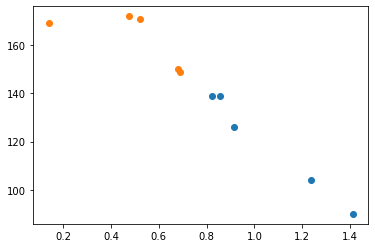

7.777784733840525


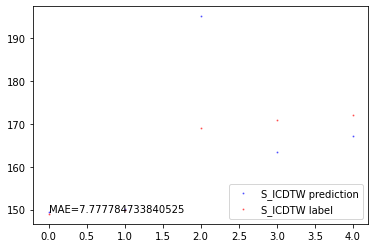

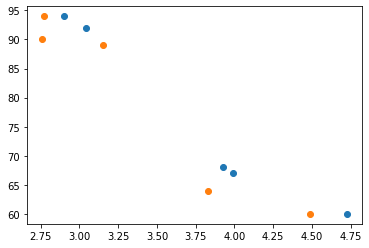

3.7566521922387324


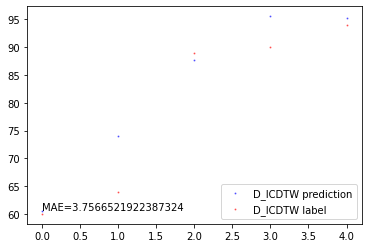

In [77]:
from sklearn.linear_model import LinearRegression as LR

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(ICDTW_features_train[:, 0],ICDTW_features_test[:, 0],labels_0_train[idxs_train, 4],labels_0_test[idxs_train, 4],'S_ICDTW')
plot_plot(ICDTW_features_train[:, 1],ICDTW_features_test[:, 1],labels_0_train[idxs_train, 5],labels_0_test[idxs_train, 5],'D_ICDTW')


In [76]:
def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()